### Chapter 3 - Computer Vision

**This week's exercise has 4 tasks, for a total of 10 points. Don't forget to submit your solutions to GitHub!**

In this chapter, we want you to become proficient at the following tasks:
- Building a modern PyTorch segmentation model
- Training a modern model on a real-world segmentation task and achieving passable results

**Note**: This is the last exercise concerning pure computer vision. Starting next week, we will begin with Natural Language Processing, i.e. text data. Therefore, don't worry too much if this exercise feels hard or if you can't complete all of it ;)

#### Chapter 3.5 - Segmentation

In previous tasks, we solved classification problems - we provide some input(s), typically an image, and get out a few numbers, which are the predicted pseudo-probabilities that our input belongs to some class, such as "tumor" or "no tumor". For this exercise, we will explore a new task that is extremely common in medical AI research and in clinical practice. This task is called segmentation. In segmentation, the goal is to go from an input image to one or several segmentations (also called *segmentation maps*) of that image. For the example of LiTS, this means that our input remains the same - a 256x256 image with 1 channel. However, our model outputs and targets are now different - they also have the shape 256x256 pixels, times the number of output classes, in our case 3 (background, liver, liver+tumor). Each 256x256 output is basically a map of which pixels in the original image belong to a certain class with what (pseudo-)probability. The training objective, in its simplest form, is also the same; Cross-Entropy Loss, but per pixel, instead of per-image.

To solve today's tasks, we will need to build ourselves a few new things that look almost the same as things we have already built.

**Task 1 (2 points)**: We will need a new Dataset class. It is the same as usual, except this time, when we return image and target in the getitem method, our target is now also a multi-dimensional tensor of size.

We will return two kinds of targets - class-index targets and one-hot encoded targets. Class-index targets you already know. Every pixel is assigned a class, which can be 0 for background, 1 for liver, and 2 for lesions. The corresponding tensor has the size $H * W$. One-hot encoded targets instead have size $C * H * W$ - each channel is one class (the 0th channel is background, etc.), and the values for each pixel in a channel are 1 if that pixel belongs to that class and 0 if not. We will need both later on - class-index targets because that is the input for the normal CrossEntropyLoss, and one-hot targets because we will use them in this format for our DiceLoss.

Since the "background" class has no segmentations, you will have to improvise them from the existing segmentations for this task.

Your dataset class should return both targets at the end of the \_\_getitem\_\_ method like this: `return image, c_targets, oh_targets`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Download our data again:
#!gdown 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
#!rm -rf ./sample_data/
!rm -rf ./Clean_LiTS
!unzip -qq ./drive/MyDrive/Clean_LiTS.zip -d .
#!rm ./Clean_LiTS.zip

Mounted at /content/drive


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as ttf
import torch.nn.functional as F
import matplotlib.pyplot as plt

class LiTS_Segmentation_Dataset(Dataset):
    def __init__(self, csv: str, mode: str):

        self.csv = csv
        self.data = pd.read_csv(self.csv)
        self.mode = mode
        self.img_dir = f"./Clean_LiTS/{mode}"
        assert mode in ["train", "val", "test"] # has to be train, val, or test data - if not, assert throws an error

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        file = self.data.loc[idx, "filename"]
        with PIL.Image.open(f"./Clean_LiTS/{self.mode}/{file}") as f:
            f = f.convert("L")
            image = ttf.pil_to_tensor(f)

        # With this
        image = image.to(torch.float32)

        # Typical CT window for abdominal soft tissue
        window_center = 40
        window_width = 300

        image = (image - window_center) / window_width
        image = torch.clamp(image, -1, 1)

        row=self.data.iloc[idx]
        # 2. Load the Segmentation Masks
        # The CSV has columns pointing to the separate mask files
        liver_mask_name = row['liver_segmentation']
        lesion_mask_name = row['lesion_segmentation']

        liver_path = os.path.join(self.img_dir, liver_mask_name)
        lesion_path = os.path.join(self.img_dir, lesion_mask_name)

        liver_mask = Image.open(liver_path).convert("L")
        lesion_mask = Image.open(lesion_path).convert("L")

        # Convert masks to tensors [1, H, W]
        liver_tensor = ttf.to_tensor(liver_mask)
        lesion_tensor = ttf.to_tensor(lesion_mask)

        # 3. Create Class-Index Target (c_targets)
        # Start with a background of zeros [H, W]
        c_targets = torch.zeros(image.shape[1:], dtype=torch.long)

        # Mark liver pixels as 1
        # We check where pixel value > 0 (since loaded masks might be 0-255 or 0-1)
        c_targets[liver_tensor.squeeze(0) > 0] = 1

        # Mark lesion pixels as 2 (This overwrites liver, which is correct)
        c_targets[lesion_tensor.squeeze(0) > 0] = 2

        # 4. Create One-Hot Target (oh_targets)
        # F.one_hot creates [H, W, C], we need [C, H, W] for PyTorch
        num_classes = 3
        oh_targets = F.one_hot(c_targets, num_classes=num_classes) # [H, W, 3]
        oh_targets = oh_targets.permute(2, 0, 1).float()           # [3, H, W]

        return image, c_targets, oh_targets

# --- Setup DataLoaders ---
train_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/train_classes.csv", mode="train")
val_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/val_classes.csv", mode="val")
test_dataset = LiTS_Segmentation_Dataset(csv = "./Clean_LiTS/test_classes.csv", mode="test")

batch_size = 16

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    num_workers = 1,
    prefetch_factor = 2,
    shuffle = True,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = 1,
    shuffle = True,
    drop_last = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = 1,
    shuffle = True,
    drop_last = True
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train size: 35484
Val size: 3039


**Task 2 (2 points)**: Plot a few images that contain livers and tumors, as well as their corresponding segmentation maps. Do they look correct? Is there anything special to note?

--- Visualizing Training Sample ---


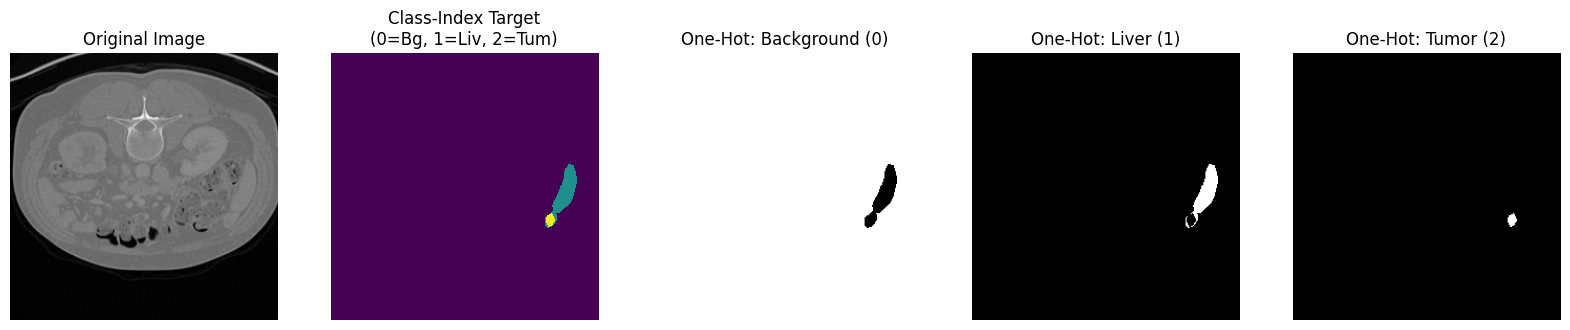

Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum of channels (should be 1 everywhere): 1.0


In [3]:
# Function to visualize the triplet (Image, Class Target, One-Hot Channels)
def visualize_sample(dataset):
    # Find an index that has a tumor so the plot is interesting
    tumor_indices = dataset.data.index[dataset.data['lesion_visible'] == True].tolist()
    if not tumor_indices:
        print("No tumors found in this split!")
        idx = 0
    else:
        idx = tumor_indices[0] # Take the first one with a tumor

    image, c_target, oh_target = dataset[idx]

    # Prepare for plotting
    # Image: [1, H, W] -> [H, W]
    img_show = image.squeeze(0)

    # Class Target: [H, W] (Values 0,1,2)

    # One-Hot: [3, H, W] -> We'll plot each channel separately

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # 1. Original CT Scan
    axes[0].imshow(img_show, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # 2. Combined Class Target
    # We use a colormap where 0=Black, 1=Greenish, 2=Yellowish
    axes[1].imshow(c_target, cmap="viridis", interpolation="nearest")
    axes[1].set_title("Class-Index Target\n(0=Bg, 1=Liv, 2=Tum)")
    axes[1].axis("off")

    # 3. One-Hot: Background Channel
    axes[2].imshow(oh_target[0], cmap="gray")
    axes[2].set_title("One-Hot: Background (0)")
    axes[2].axis("off")

    # 4. One-Hot: Liver Channel
    axes[3].imshow(oh_target[1], cmap="gray")
    axes[3].set_title("One-Hot: Liver (1)")
    axes[3].axis("off")

    # 5. One-Hot: Tumor Channel
    axes[4].imshow(oh_target[2], cmap="gray")
    axes[4].set_title("One-Hot: Tumor (2)")
    axes[4].axis("off")

    plt.show()

    # Sanity Check
    print(f"Image Shape: {image.shape}")
    print(f"Class Target Shape: {c_target.shape} | Unique Values: {torch.unique(c_target)}")
    print(f"One-Hot Target Shape: {oh_target.shape} | Sum of channels (should be 1 everywhere): {oh_target.sum(dim=0).mean().item()}")

print("--- Visualizing Training Sample ---")
visualize_sample(train_dataset)

--- Visualizing 3 Random Samples ---
Selected indices: [30837, 10257, 30883]


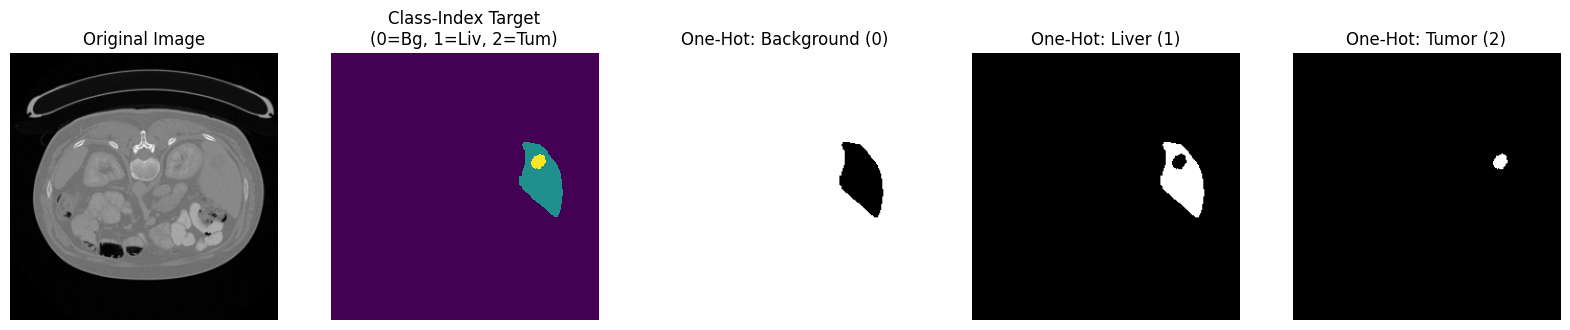

Sample idx = 30837
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


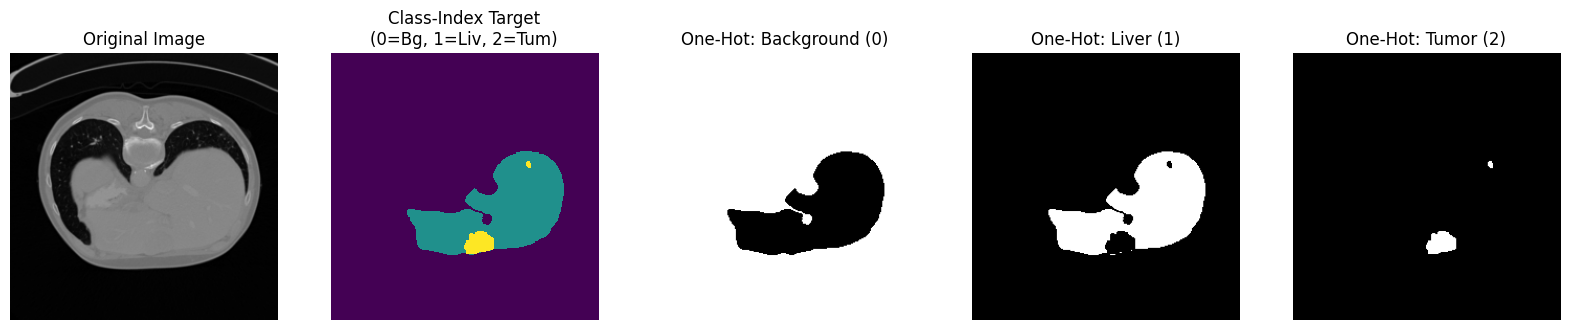

Sample idx = 10257
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


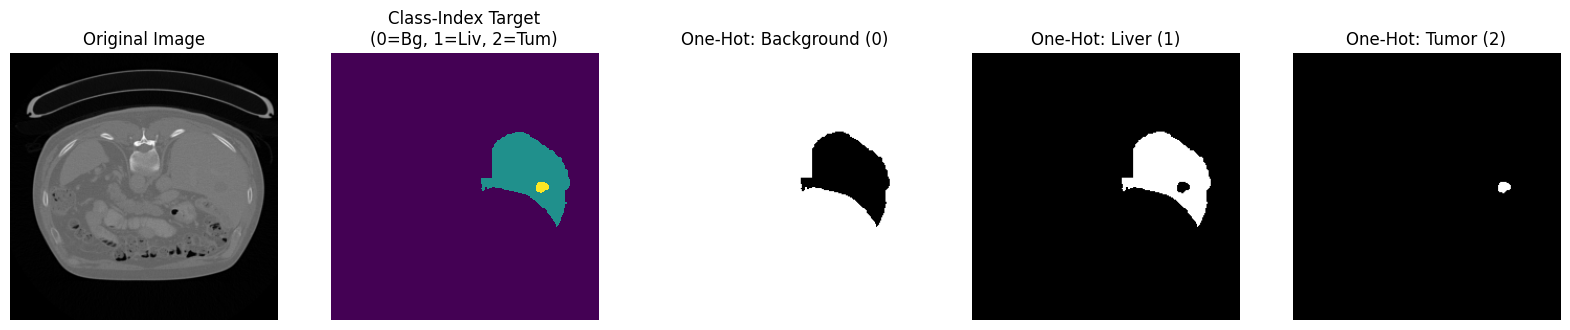

Sample idx = 30883
Image Shape: torch.Size([1, 256, 256])
Class Target Shape: torch.Size([256, 256]) | Unique Values: tensor([0, 1, 2])
One-Hot Target Shape: torch.Size([3, 256, 256]) | Sum-of-channels mean: 1.0
------------------------------------------------------------


In [4]:
import random
import matplotlib.pyplot as plt
import torch

def visualize_three_samples(dataset):

    # --- Choose indices that contain tumors (if available) ---
    if "lesion_visible" in dataset.data.columns:
        tumor_indices = dataset.data.index[dataset.data['lesion_visible'] == True].tolist()
    else:
        tumor_indices = []

    # If no tumor slices known, fallback to 3 random indices
    if len(tumor_indices) >= 3:
        selected_indices = random.sample(tumor_indices, 3)
    else:
        selected_indices = random.sample(range(len(dataset)), 3)

    print(f"Selected indices: {selected_indices}")

    # --- Plot each selected sample ---
    for idx in selected_indices:
        image, c_target, oh_target = dataset[idx]

        img_show = image.squeeze(0)

        fig, axes = plt.subplots(1, 5, figsize=(20, 5))

        # 1. Original Image
        axes[0].imshow(img_show, cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # 2. Class-Index (0,1,2)
        axes[1].imshow(c_target, cmap="viridis", interpolation="nearest")
        axes[1].set_title("Class-Index Target\n(0=Bg, 1=Liv, 2=Tum)")
        axes[1].axis("off")

        # 3. Background Channel
        axes[2].imshow(oh_target[0], cmap="gray")
        axes[2].set_title("One-Hot: Background (0)")
        axes[2].axis("off")

        # 4. Liver Channel
        axes[3].imshow(oh_target[1], cmap="gray")
        axes[3].set_title("One-Hot: Liver (1)")
        axes[3].axis("off")

        # 5. Tumor Channel
        axes[4].imshow(oh_target[2], cmap="gray")
        axes[4].set_title("One-Hot: Tumor (2)")
        axes[4].axis("off")

        plt.show()

        # Sanity check
        print(f"Sample idx = {idx}")
        print(f"Image Shape: {image.shape}")
        print(f"Class Target Shape: {c_target.shape} | Unique Values: {torch.unique(c_target)}")
        print(f"One-Hot Target Shape: {oh_target.shape} | Sum-of-channels mean: {oh_target.sum(dim=0).mean().item()}")
        print("-" * 60)


# --- Run ---
print("--- Visualizing 3 Random Samples ---")
visualize_three_samples(train_dataset)


Background is artificially made

**Task 3 (2 points)**: Next, we need a different loss function. At the bottom, we provide a training/testing loop that already contains cross-entropy loss and a functional segmentation model, plus evaluation. We have learned in the lecture that DICE score, and by extension a DICE-based loss, can be useful for imbalanced classes. We have also discovered that LiTS 2017 contains a class imbalance - slices with tumors are much more rare than slices with livers. Hence, we will make our own DICE loss.

The formula for the DICE loss is computed as follows: $1 - \frac{2 * (|X \land Y|)+\epsilon}{|X|+|Y|+\epsilon}$, where $X$ is the prediction and $Y$ the target.

The DICE Loss class you create should fulfill the following criteria:
- It subclasses torch.nn.module.
- It is a class that implements an \_\_init\_\_ function.
- The loss also implements a \_\_forward\_\_ function that accepts as inputs a prediction tensor and a target tensor, both of shape B x 3 x 256 x 256 - 3 channels because we will segment background, liver, and liver+tumor again. The output is the computed loss.
- You may add class weighting to offset the class imbalance.

Your total loss should be `total_loss = ce_loss + dice_loss`, and your backward pass should be `total_loss.backward()`.
Run the training for a few epochs, once with and once without DICE loss included as part of the overall loss. In your experiment, which version worked better?

In [5]:
import torch, torch.nn as nn, torch.nn.functional as nnf

def compute_dice_score(prediction: torch.Tensor, target: torch.Tensor):

    prediction = prediction.to(dtype = torch.bool)
    target = target.to(dtype = torch.bool)

    intersection = torch.sum(prediction * target)   # TP
    p_cardinality = torch.sum(prediction)           # TP+FP
    t_cardinality = torch.sum(target)               # TP+FN
    cardinality = p_cardinality + t_cardinality
    eps = 1e-8

    if cardinality != 0:
        dice = (2 * intersection + eps) / (cardinality + eps) # 2*TP / (2*TP+FP+FN + eps)
    else:
        dice = None

    return dice

class BinaryDiceLoss(nn.Module):
    """
    Computes Dice loss for a single class channel.
    prediction: B x H x W (values between 0 and 1)
    target:     B x H x W (0/1 one-hot)
    """
    def __init__(self, weight: float=1.0):
        super().__init__()
        self.weight =weight


    def forward(self, prediction, target):

        eps=1e-8

        # Flatten to (B, -1)
        pred_flat = prediction.reshape(-1)
        target_flat = target.reshape(-1)

        intersection = torch.sum(pred_flat*target_flat)
        cardinality = torch.sum(pred_flat) + torch.sum(target_flat)

        dice = (2.0 * intersection + eps) / (cardinality + eps)
        return self.weight*(1.0 - dice)


class DiceLoss(nn.Module):
    """
    Multi-class Dice loss.
    predictions: B x C x H x W (softmax probabilities)
    targets:     B x C x H x W (one-hot)
    """
    def __init__(self, num_classes=3, class_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.binary_loss = BinaryDiceLoss()

        if class_weights is None:
            # Background gets weight 1, liver 1, tumor HIGHER because rare
            self.class_weights = torch.tensor([1.0, 1.0, 4.0])
        else:
            self.class_weights = torch.tensor(class_weights)

    def forward(self, predictions, targets):
        """
        predictions: softmax output, shape (B, C, H, W)
        targets: one-hot, shape (B, C, H, W)
        """
        dice_total = 0.0

        for c in range(self.num_classes):
            dice_c = self.binary_loss(predictions[:, c], targets[:, c])
            dice_total += self.class_weights[c] * dice_c

        # Normalize by sum of weights
        return dice_total / self.class_weights.sum()



In [6]:
import torch.optim as optimizer
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, 1)  # logits für jede Klasse
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # B x C x H x W


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
num_epochs = 5
learning_rate = 1e-3

# Modell
model = SimpleSegModel(in_channels=3, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss-Funktionen
ce_loss_fn = nn.CrossEntropyLoss()
dice_loss_fn = DiceLoss(num_classes=num_classes)

# Dummy DataLoader (ersetze durch echte Daten)
from torch.utils.data import DataLoader, TensorDataset

# Beispiel: 20 Bilder, 3x64x64
images = torch.randn(20, 3, 64, 64)
c_targets = torch.randint(0, num_classes, (20, 64, 64))        # Klassenindices
oh_targets = F.one_hot(c_targets, num_classes=num_classes).permute(0,3,1,2).float()  # One-hot

dataset = TensorDataset(images, c_targets, oh_targets)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [14]:
def train_model(use_dice=True):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, c_targets, oh_targets in train_dataloader:
            images = images.to(device)
            c_targets = c_targets.to(device)
            oh_targets = oh_targets.to(device)

            optimizer.zero_grad()
            predictions = model(images)           # B x C x H x W
            probs = F.softmax(predictions, dim=1)

            ce_loss = ce_loss_fn(predictions, c_targets)
            if use_dice:
                dice_loss = dice_loss_fn(probs, oh_targets)
                total_loss = ce_loss + dice_loss
            else:
                total_loss = ce_loss

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        avg_loss = running_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

print("Training mit Cross-Entropy + Dice-Loss:")
train_model(use_dice=True)

print("\nTraining nur mit Cross-Entropy-Loss:")
train_model(use_dice=False)


Training mit Cross-Entropy + Dice-Loss:
Epoch [1/5] - Loss: 1.7667
Epoch [2/5] - Loss: 1.7653
Epoch [3/5] - Loss: 1.7648
Epoch [4/5] - Loss: 1.7645
Epoch [5/5] - Loss: 1.7640

Training nur mit Cross-Entropy-Loss:
Epoch [1/5] - Loss: 1.0971
Epoch [2/5] - Loss: 1.0966
Epoch [3/5] - Loss: 1.0961
Epoch [4/5] - Loss: 1.0955
Epoch [5/5] - Loss: 1.0949


**Task 4 (4 points)**: Finally, we want to make our own model that can handle segmentations. For this course, we will build ourselves a U-Net. The original paper can be found here: https://arxiv.org/pdf/1505.04597.

The input dimensions for the network will be the usual B x 1 x 256 x 256. The output dimensions should be B x 3 x 256 x 256. We have three output channels because we will still predict classes 0 (background), 1 (liver) and 2 (liver tumor) - this time, however, we predict the classes on a per-pixel basis.

Since our input images have vastly smaller dimensions compared to those used in the original UNet-Paper, we will opt for a different scale of UNet. The general design remains the same as in the paper, except:

- We will only downsample 3 times by a factor of 2, using MaxPool (for a minimum resolution 32x32).
- Our 3x3 Convolutions will have Padding. Consequently, there will be no cropping during skip connections
- We will only have 3 skip connections.
- We will go for fewer maximum channels (as we have only 3 downsampling steps, we will have 64, 128, 256, and 512 channels).
- Our final output will be 3 channels wide, not 2 (we predict background, liver, and liver tumors).

Note that training a segmentation models takes a little while - we do not award points for results here, because it would mean that you would have to wait a long time to see whether your changes helped performance. All we want to see is that your model learns anything useful at all. As a rough guideline, you will probably start seeing ok liver segmentations after 1 epoch, and good liver and ok lesion segmentations after 2 or 3 epochs.

If everything works correctly, you can copy the previous training loop and should get some good results. Don't forget to look at some of your predictions! Are they reasonable? Empty? Weird? Can you discover some kind of systemic issues with your predictions?

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 3, base_channels: int = 32, dropout: float = 0.1):
        super().__init__()
        def double_conv(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        self.enc1 = double_conv(in_channels, base_channels)
        self.enc2 = double_conv(base_channels, base_channels * 2)
        self.enc3 = double_conv(base_channels * 2, base_channels * 4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = nn.Sequential(
            double_conv(base_channels * 4, base_channels * 8),
            nn.Dropout(dropout),
        )
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.dec3 = double_conv(base_channels * 8, base_channels * 4)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = double_conv(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = double_conv(base_channels * 2, base_channels)
        self.classifier = nn.Conv2d(base_channels, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        c1 = self.enc1(x)
        c2 = self.enc2(self.pool(c1))
        c3 = self.enc3(self.pool(c2))
        # Bottleneck
        b = self.bottleneck(self.pool(c3))
        # Decoder with skip connections
        u3 = self.up3(b)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.dec3(u3)
        u2 = self.up2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec2(u2)
        u1 = self.up1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.dec1(u1)
        return self.classifier(d1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
num_epochs = 12
learning_rate = 2e-4
weight_decay = 1e-4
dice_weight = 1.0
ce_weight = 0.8
gradient_clip = 1.0
train_batch_size = 8
model = UNet(in_channels=1, num_classes=num_classes, base_channels=32, dropout=0.1)
model = model.to(device)
dice_loss = DiceLoss(num_classes = 3).to(device) # Your dice loss class goes here
ce_loss = nn.CrossEntropyLoss(
    weight = torch.tensor([1.0, 2.5, 8.0]).to(device = device),
    reduction = "mean",
    #ignore_index = 0
    )
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
loader_workers = max(1, min(4, os.cpu_count() // 2 if os.cpu_count() else 0))
loader_kwargs = dict(num_workers = loader_workers, pin_memory = torch.cuda.is_available())
if loader_kwargs["num_workers"] > 0:
    loader_kwargs["prefetch_factor"] = 2
    loader_kwargs["persistent_workers"] = True

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    drop_last = True,
    **loader_kwargs,
 )
val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = train_batch_size,
    shuffle = False,
    drop_last = False,
    **loader_kwargs,
 )

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = train_batch_size,
    shuffle = False,
    drop_last = False,
    **loader_kwargs,
 )

In [19]:
# If your model and loss work, this should at least execute successfully.
# If you only wish to test your model, just comment out the dice_loss component everywhere.
from tqdm.auto import tqdm
best_val_loss = float("inf")
history = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_train_samples = 0
    for data, c_targets, oh_targets in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
        predictions = model(data)
        probs = torch.softmax(predictions, dim=1)
        loss_1 = dice_loss(probs, oh_targets)
        loss_2 = ce_loss(predictions, c_targets)
        total_loss = loss_1 * dice_weight + loss_2 * ce_weight
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
        optimizer.step()
        train_loss += total_loss.item() * data.size(0)
        num_train_samples += data.size(0)
    train_loss = train_loss / max(1, num_train_samples)
    # Validate once after every epoch
    model.eval()
    with torch.no_grad():
        val_loss_total = 0.0
        val_samples = 0
        background_sum = liver_sum = lesion_sum = 0.0
        background_count = liver_count = lesion_count = 0
        for val_step, (data, c_targets, oh_targets) in enumerate(tqdm(val_dataloader, leave=False)):
            data, c_targets, oh_targets = data.to(device), c_targets.to(device), oh_targets.to(device)
            predictions = model(data)
            probs = torch.softmax(predictions, dim=1)
            # loss
            loss_1 = dice_loss(probs, oh_targets)
            loss_2 = ce_loss(predictions, c_targets)
            total_loss = loss_1 * dice_weight + loss_2 * ce_weight
            batch_size_now = data.size(0)
            val_loss_total += total_loss.item() * batch_size_now
            val_samples += batch_size_now
            p_arg = nnf.one_hot(torch.argmax(probs, dim = 1), num_classes = 3).moveaxis(-1, 1)
            background_seg = oh_targets[:, 0, :, :]
            liver_seg = oh_targets[:, 1, :, :]
            lesion_seg = oh_targets[:, 2, :, :]
            background_dice = compute_dice_score(p_arg[:,0,:,:], background_seg)
            if background_dice is not None:
                background_sum += background_dice.item() * batch_size_now
                background_count += batch_size_now
            if liver_seg.sum() != 0.0:
                liver_dice = compute_dice_score(p_arg[:,1,:,:], liver_seg)
                if liver_dice is not None:
                    liver_sum += liver_dice.item() * batch_size_now
                    liver_count += batch_size_now
            if lesion_seg.sum() != 0.0:
                lesion_dice = compute_dice_score(p_arg[:,2,:,:], lesion_seg)
                if lesion_dice is not None:
                    lesion_sum += lesion_dice.item() * batch_size_now
                    lesion_count += batch_size_now
        avg_background_dice = (background_sum / background_count) if background_count else 0.0
        avg_liver_dice = (liver_sum / liver_count) if liver_count else 0.0
        avg_lesion_dice = (lesion_sum / lesion_count) if lesion_count else 0.0
        val_loss = val_loss_total / max(1, val_samples)
        scheduler.step(val_loss)
        history.append(dict(epoch=epoch+1, train_loss=train_loss, val_loss=val_loss, background_dice=avg_background_dice, liver_dice=avg_liver_dice, lesion_dice= avg_lesion_dice))
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch+1},    LR: {current_lr:.2e},   Train Loss: {train_loss:.4f},   Validation Loss: {val_loss:.4f}, Background Dice:{avg_background_dice: .4f}, Liver Dice score: {avg_liver_dice: .4f}, Lesion Dice Score:{avg_lesion_dice: .4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
        # After we are done validating, let's not forget to go back to storing gradients.
        model.train()

  0%|          | 0/4435 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch: 1,    LR: 2.00e-04,   Train Loss: 0.8203,   Validation Loss: 0.8022, Background Dice: 0.9961, Liver Dice score:  0.6860, Lesion Dice Score: 0.1532


  0%|          | 0/4435 [00:00<?, ?it/s]

KeyboardInterrupt: 

Visualizing model predictions on test data (at least one sample per class):
Selected indices: [1132, 363, 779, 2361, 1985]


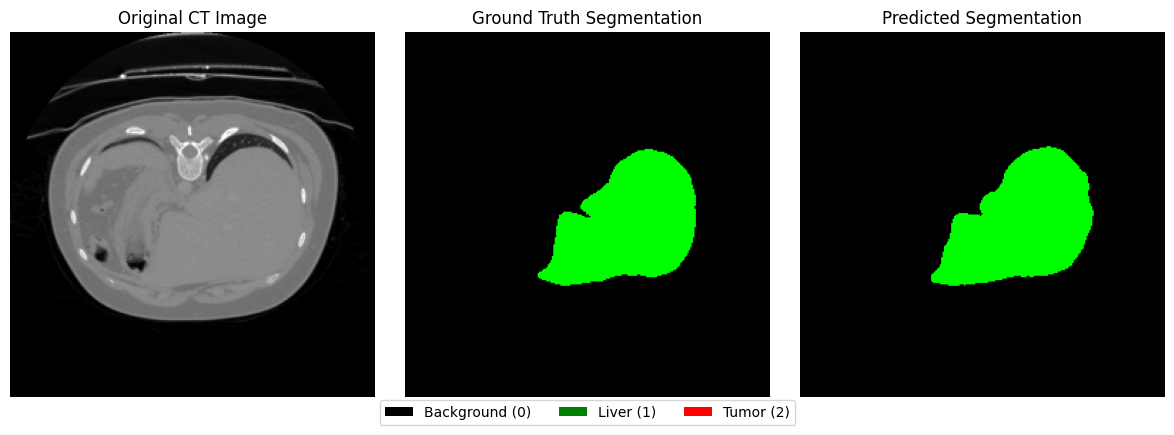

Sample 1132:
  Ground Truth Classes: {np.int64(0), np.int64(1)}
  Predicted Classes: {np.int64(0), np.int64(1)}
--------------------------------------------------


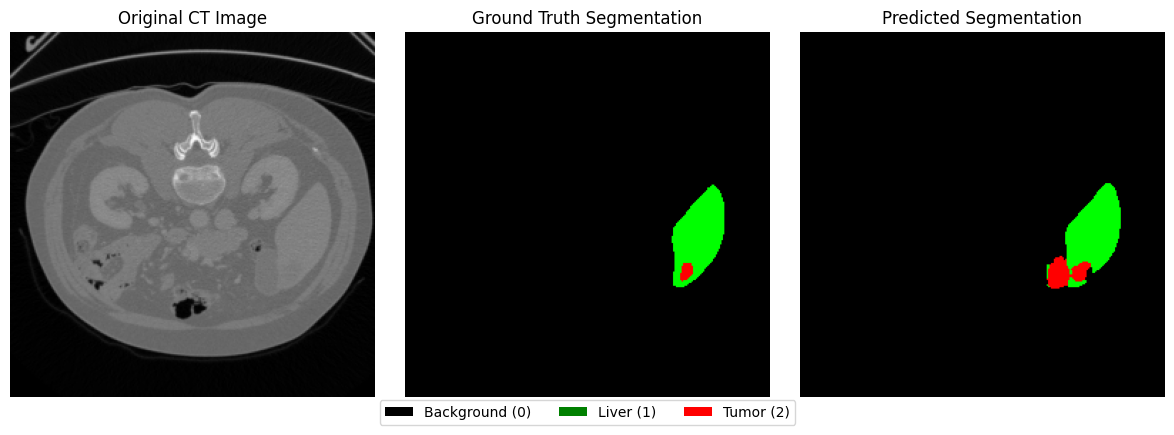

Sample 363:
  Ground Truth Classes: {np.int64(0), np.int64(1), np.int64(2)}
  Predicted Classes: {np.int64(0), np.int64(1), np.int64(2)}
--------------------------------------------------


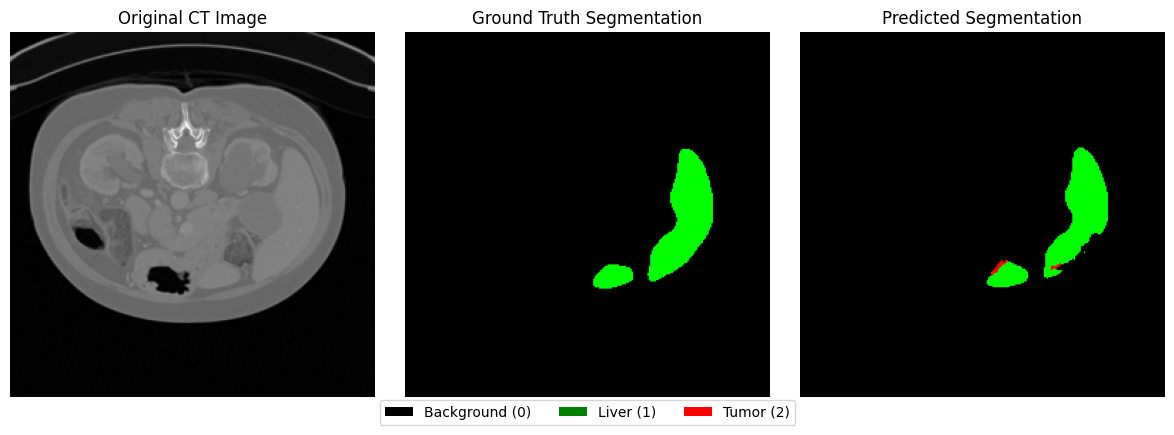

Sample 779:
  Ground Truth Classes: {np.int64(0), np.int64(1)}
  Predicted Classes: {np.int64(0), np.int64(1), np.int64(2)}
--------------------------------------------------


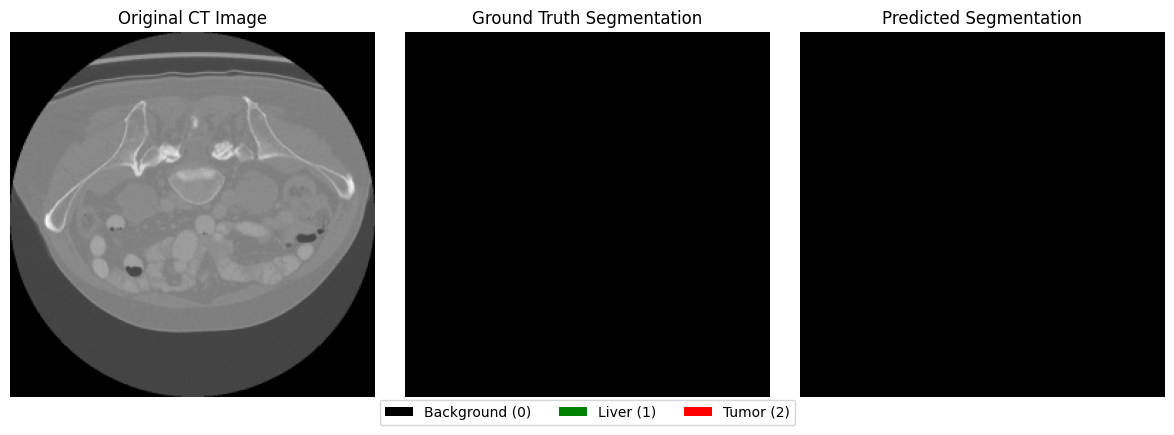

Sample 2361:
  Ground Truth Classes: {np.int64(0)}
  Predicted Classes: {np.int64(0)}
--------------------------------------------------


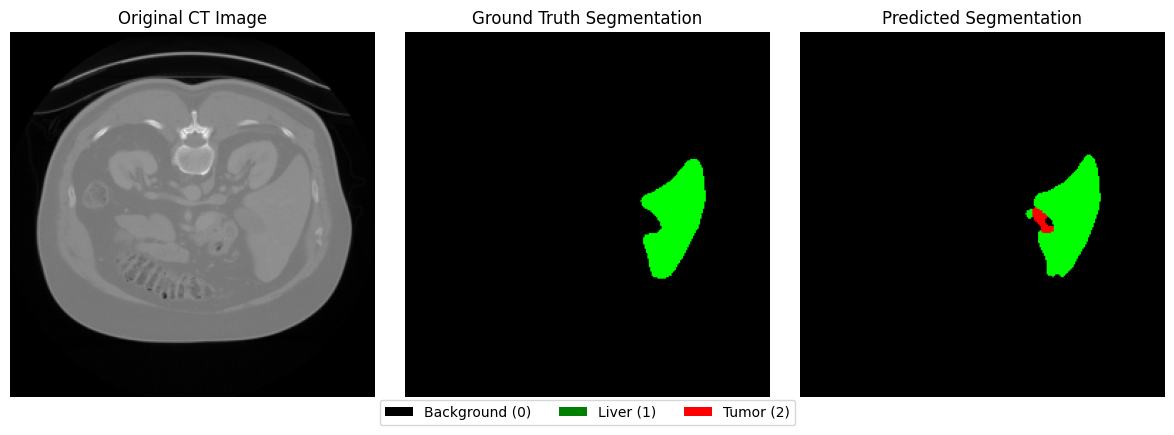

Sample 1985:
  Ground Truth Classes: {np.int64(0), np.int64(1)}
  Predicted Classes: {np.int64(0), np.int64(1), np.int64(2)}
--------------------------------------------------


In [20]:
# Try looking at some images and predicted segmentations to see how badly or how well you've done
import random
import numpy as np
def visualize_predictions(dataset, model, device, num_samples=5):
    """
    Visualize predictions from the model on a few test samples.
    Ensures at least one sample with liver and one with tumor.
    Shows original image, ground truth segmentation, and predicted segmentation.
    """
    # Define colors for classes: Background=Black, Liver=Green, Tumor=Red
    colors = np.array([
        [0, 0, 0],      # Background: Black
        [0, 255, 0],    # Liver: Green
        [255, 0, 0]     # Tumor: Red
    ]) / 255.0  # Normalize to [0,1]

    # Select indices: at least one with liver, one with tumor, rest random
    liver_indices = dataset.data.index[dataset.data['liver_visible'] == True].tolist()
    tumor_indices = dataset.data.index[dataset.data['lesion_visible'] == True].tolist()

    selected_indices = []

    # Add one with liver if available
    if liver_indices:
        selected_indices.append(random.choice(liver_indices))

    # Add one with tumor if available and different from liver one
    if tumor_indices:
        tumor_choice = random.choice(tumor_indices)
        if tumor_choice not in selected_indices:
            selected_indices.append(tumor_choice)
        elif len(tumor_indices) > 1:
            # Try another
            tumor_indices.remove(tumor_choice)
            selected_indices.append(random.choice(tumor_indices))

    # Fill the rest with random samples
    remaining = num_samples - len(selected_indices)
    all_indices = list(range(len(dataset)))
    random_indices = random.sample([i for i in all_indices if i not in selected_indices], remaining)
    selected_indices.extend(random_indices)

    # Ensure we have exactly num_samples
    selected_indices = selected_indices[:num_samples]
    print(f"Selected indices: {selected_indices}")

    for idx in selected_indices:
        image, c_targets, oh_targets = dataset[idx]

        # Prepare image for display
        img_show = image.squeeze(0).cpu().numpy()

        # Ground truth segmentation (class indices)
        gt_seg = c_targets.cpu().numpy()
        gt_rgb = colors[gt_seg]  # Shape: (H, W, 3)

        # Make prediction
        model.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
            predictions = model(input_tensor)
            probs = torch.softmax(predictions, dim=1)
            pred_seg = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()  # Remove batch dimension
            pred_rgb = colors[pred_seg]  # Shape: (H, W, 3)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Original Image
        axes[0].imshow(img_show, cmap="gray")
        axes[0].set_title("Original CT Image")
        axes[0].axis("off")

        # Ground Truth Segmentation
        axes[1].imshow(gt_rgb)
        axes[1].set_title("Ground Truth Segmentation")
        axes[1].axis("off")

        # Predicted Segmentation
        axes[2].imshow(pred_rgb)
        axes[2].set_title("Predicted Segmentation")
        axes[2].axis("off")

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='black', label='Background (0)'),
            Patch(facecolor='green', label='Liver (1)'),
            Patch(facecolor='red', label='Tumor (2)')
        ]
        fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

        plt.tight_layout()
        plt.show()

        # Print some stats
        print(f"Sample {idx}:")
        print(f"  Ground Truth Classes: {set(gt_seg.flatten())}")
        print(f"  Predicted Classes: {set(pred_seg.flatten())}")
        print("-" * 50)
# Visualize 5 random test samples, ensuring at least one with liver and one with tumor
print("Visualizing model predictions on test data (at least one sample per class):")
visualize_predictions(test_dataset, model, device, num_samples=5)